In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('../..')))

In [2]:
import numpy as np 
import scipy.fft
from operators.mixed_method_0.mixed_method_0_operators import charge_density_two_stream_mixed_method_0
from operators.legendre.legendre_operators import xi_legendre
from operators.hermite.hermite_operators import psi_hermite
from operators.mixed_method_1.setup_mixed_method_1_two_stream import SimulationSetupMixedMethod1
from operators.poisson_solver import gmres_solver
from operators.hermite.hermite_operators import total_mass_hermite, total_momentum_hermite, total_energy_k_hermite
from operators.legendre.legendre_operators import total_mass_legendre, total_momentum_legendre, total_energy_k_legendre

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from mycolorpy import colorlist as mcp
import matplotlib
font = {'family' : 'serif',
        'size'   : 14}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

# Enable LaTeX rendering
matplotlib.rcParams['text.usetex'] = True

# Mixed method #1 bump on tail 

In [4]:
setup = SimulationSetupMixedMethod1(Nx=101,
                                    Nv_H=50,
                                    Nv_L=50,
                                    epsilon=1e-2,
                                    v_a=-7,
                                    v_b=7,
                                    alpha=np.sqrt(2),
                                    u=0,
                                    L=20 * np.pi / 3,
                                    dt=1e-2,
                                    T0=0,
                                    T=40,
                                    nu_L=1,
                                    nu_H=1,
                                    gamma=0.5)

NameError: name 'SimulationSetupMixedMethod0' is not defined

In [ ]:
# ions (unperturbed)
C0_ions = np.ones(setup.Nx)

In [ ]:
# spatial grid 
x = np.linspace(0, setup.L, setup.Nx+1)
v_ = np.linspace(setup.v_a, setup.v_b, 1000, endpoint=True)

# simulation results

In [5]:
skip = 1
# load the simulation results
# save results
sol_midpoint_u = np.load("../../data/mixed_method_1/bump_on_tail/sol_u_NvH_" + str(setup.Nv_H) + "_NvL_" + str(setup.Nv_L) +
            "_Nx_" + str(setup.Nx) + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")
sol_midpoint_t = np.load("../../data/mixed_method_1/bump_on_tail/sol_t_NvH_" + str(setup.Nv_H) + "_NvL_" + str(setup.Nv_L) +
            "_Nx_" + str(setup.Nx) + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")

dt = 0.01 * skip

# print simulation dimensions
print(np.shape(sol_midpoint_u))
print(np.shape(sol_midpoint_t))

NameError: name 'setup' is not defined

In [36]:
runtime = np.load("../../data/mixed_method_1/bump_on_tail/sol_runtime_NvH_" + str(setup.Nv_H) + "_NvL_" + str(setup.Nv_L) +
            "_Nx_" + str(setup.Nx) + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")
runtime

array([2834.066104  ,  473.49444318])

In [37]:
# initialize the electric potential
E_midpoint = np.zeros((setup.Nx + 1, len(sol_midpoint_t)))

In [38]:
# initialize the states for implicit midpoint (symplectic)
state_e_H = np.zeros((setup.Nv_H,  setup.Nx + 1, len(sol_midpoint_t)))
state_e_L = np.zeros((setup.Nv_L,  setup.Nx + 1, len(sol_midpoint_t)))

for ii in np.arange(0, len(sol_midpoint_t)):
    # immobile ions
    state_e_H[:, :-1, ii]  = np.reshape(sol_midpoint_u[:setup.Nv_H*setup.Nx, ii], (setup.Nv_H, setup.Nx)) 
    state_e_H[:, -1, ii] = state_e_H[:, 0, ii]
    # electrons species 2
    state_e_L[:, :-1, ii]  = np.reshape(sol_midpoint_u[setup.Nv_H*setup.Nx:, ii], (setup.Nv_L, setup.Nx))  
    state_e_L[:, -1, ii] = state_e_L[:, 0, ii]

    # solve Poisson's equation to obtain an electric field
    rho = charge_density_two_stream_mixed_method_0(q_e=setup.q_e, v_a=setup.v_a, v_b=setup.v_b, alpha_e=setup.alpha,
                         C0_e_hermite=state_e_H[0, :setup.Nx, ii], 
                         C0_e_legendre=state_e_L[0, :setup.Nx, ii])
    
    E_midpoint[:-1, ii] = gmres_solver(rhs=rho, D=setup.D, D_inv=setup.D_inv, a_tol=1e-12, r_tol=1e-12)
    E_midpoint[-1, ii] = E_midpoint[0, ii]

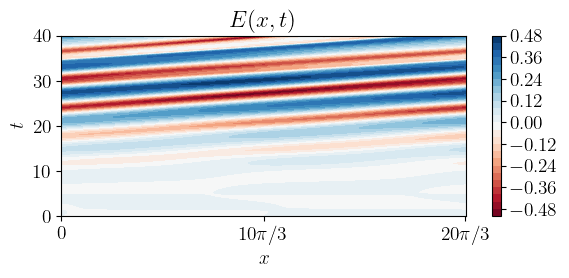

In [39]:
# plot the electric field
fig, ax = plt.subplots(figsize=(6, 3))
pos = ax.contourf(x, sol_midpoint_t, E_midpoint.T, cmap="RdBu", levels=30)
cbar = fig.colorbar(pos)
ax.set_title("$E(x, t)$")
ax.set_xlabel("$x$")
_ = ax.set_xticks([0, 10*np.pi/3, 20*np.pi/3-.05])
_ = ax.set_xticklabels([r"0", r"$10\pi/3$", r"$20\pi/3$"])
_ = ax.set_ylabel("$t$")
plt.tight_layout()

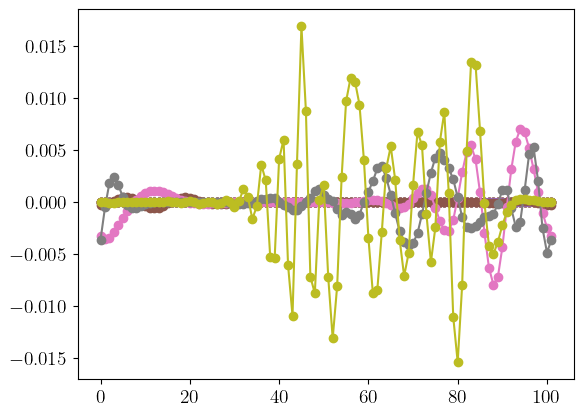

In [40]:
_ = plt.plot(state_e_H[-1, :, ::500], "-o")

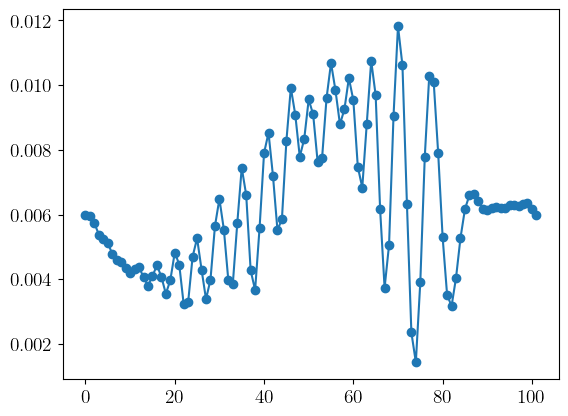

In [41]:
_ = plt.plot(state_e_L[0, :, -1], "-o")

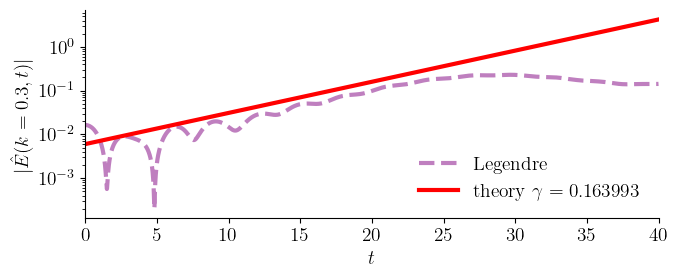

In [42]:
# plot the electric field damping rate
fig, ax = plt.subplots(figsize=(7, 3))
ax.plot(sol_midpoint_t, np.abs(np.fft.fft(E_midpoint, axis=0, norm="forward")[1, :]), "--", c="purple", alpha=0.5, linewidth=3, label="Legendre") 
ax.plot(sol_midpoint_t, 6e-3*np.exp(0.163993367317754*sol_midpoint_t), linewidth=3, color="red", label=r"theory $\gamma = 0.163993$") 

ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("$|\hat{E}(k=0.3, t)|$")
ax.set_xlabel("$ t$")
ax.set_xlim(0, setup.T)
#ax.set_ylim(1e-5, 1e-2)
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=14, loc='lower right')
legend.get_frame().set_alpha(0)
plt.tight_layout()
plt.savefig("../../figures/mixed_method_1/bump_on_tail/bump_on_tail_growth_rate_legendre.png", dpi=300)

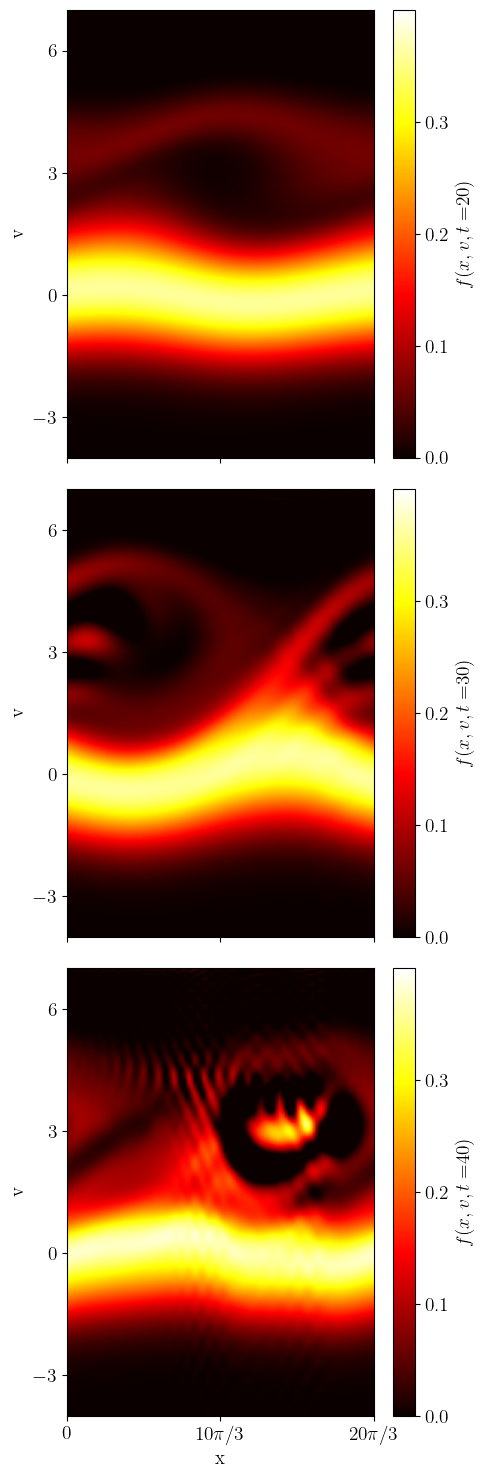

In [43]:
# plot the phase space evolution as a function of time
fig, ax = plt.subplots(nrows=3, figsize=(5, 15), sharex=True)
for tt, ii in enumerate([len(sol_midpoint_t)//2, int(3*len(sol_midpoint_t)//4), -1]):
    ii = int(ii)
    distribution_H = np.zeros((len(x), len(v_)))
    distribution_L = np.zeros((len(x), len(v_)))
    for jj in range(setup.Nv_H):
        distribution_H += np.outer(state_e_H[jj, :, ii], psi_hermite(v=v_, u_s=setup.u, alpha_s=setup.alpha, n=jj))
    for jj in range(setup.Nv_L):
        distribution_L += np.outer(state_e_L[jj, :, ii], xi_legendre(v=v_, v_b=setup.v_b, v_a=setup.v_a, n=jj))
        
    pos = ax[tt].pcolormesh(x, v_, (distribution_H + distribution_L).T, cmap="hot", vmin=0, vmax=0.4, shading="gouraud")
    ax[tt].set_yticks([-3, 0, 3, 6])
    ax[tt].set_ylabel("v")
    cbar = fig.colorbar(pos)
    cbar.ax.set_ylabel('$f(x, v, t=$' + str(int(sol_midpoint_t[ii])) + ")", rotation=90)
    cbar.ax.set_yticks([0, 0.1, 0.2, 0.3])
    #ax[tt].set_title("$f(x, v, t=$" + str(int(sol_midpoint_t[ii])) + ")")
    ax[tt].set_ylim(-4, 7)

ax[tt].set_xlabel("x")
ax[tt].set_xticks([0, 10*np.pi/3, 20*np.pi/3])
ax[tt].set_xticklabels([r"0", r"$10\pi/3$", r"$20\pi/3$"])
plt.tight_layout()
plt.savefig("../../figures/mixed_method_1/bump_on_tail/bump_on_tail_evolution_legendre.png", dpi=600)

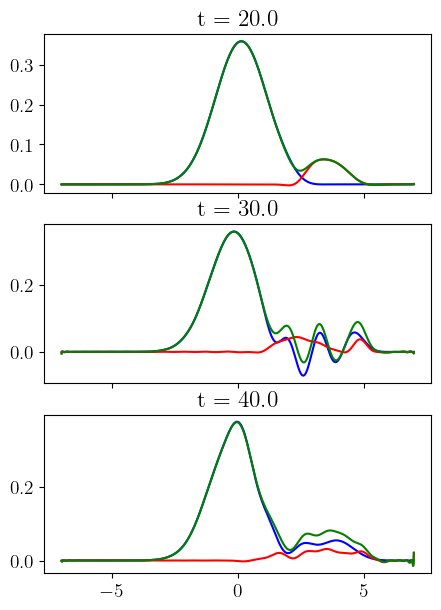

In [45]:
fig, ax = plt.subplots(nrows=3, figsize=(5, 7), sharex=True)
for tt, ii in enumerate([len(sol_midpoint_t)//2, int(3*len(sol_midpoint_t)//4), -1]):
    ii = int(ii)
    distribution_H = np.zeros((len(x), len(v_)))
    distribution_L = np.zeros((len(x), len(v_)))
    for jj in range(setup.Nv_H):
        distribution_H += np.outer(state_e_H[jj, :, ii], psi_hermite(v=v_, u_s=setup.u, alpha_s=setup.alpha, n=jj))
    for jj in range(setup.Nv_L):
        distribution_L += np.outer(state_e_L[jj, :, ii], xi_legendre(v=v_, v_b=setup.v_b, v_a=setup.v_a, n=jj))
        
    _ = ax[tt].plot(v_, distribution_H[0, :], color="blue")
    _ = ax[tt].plot(v_, distribution_L[0, :], color="red")
    _ = ax[tt].plot(v_, distribution_L[0, :] + distribution_H[0, :], color="green")
    ax[tt].set_title("t = " + str(round(sol_midpoint_t[ii], 2)))

# conservation laws: mass, momentum, and energy

### mass conservation

In [17]:
# compute mass at each timestamp
mass_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    mass_midpoint[ii] = total_mass_hermite(state=state_e_H[:, :-1, ii], alpha_s=setup.alpha, dx=setup.dx)\
                        +total_mass_legendre(state=state_e_L[:, :-1, ii], v_a=setup.v_a, v_b=setup.v_b, dx=setup.dx)

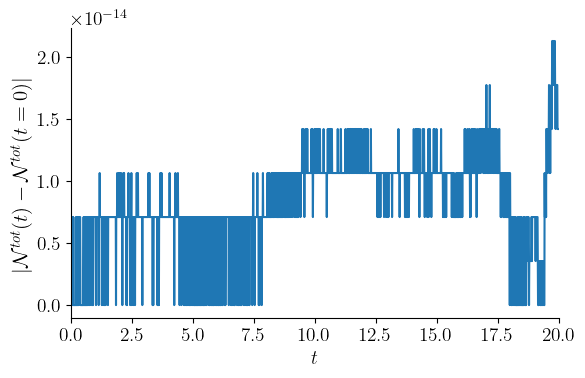

In [18]:
# plot mass conservation
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(mass_midpoint - mass_midpoint[0]), "-")
#ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|\mathcal{N}^{tot}(t) - \mathcal{N}^{tot}(t=0)|$", fontsize=15)
ax.set_xlabel("$t$")
ax.set_xlim(setup.T0, setup.T)
plt.tight_layout()

### momentum conservation

In [19]:
# compute momentum at each timestamp
momentum_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    momentum_midpoint[ii] = total_momentum_hermite(state=state_e_H[:, :-1, ii], alpha_s=setup.alpha, u_s=setup.u,
                                                   dx=setup.dx, m_s=setup.m_e)\
                            +total_momentum_legendre(state=state_e_L[:, :-1, ii], v_a=setup.v_a, v_b=setup.v_b, dx=setup.dx, m_s=setup.m_e)

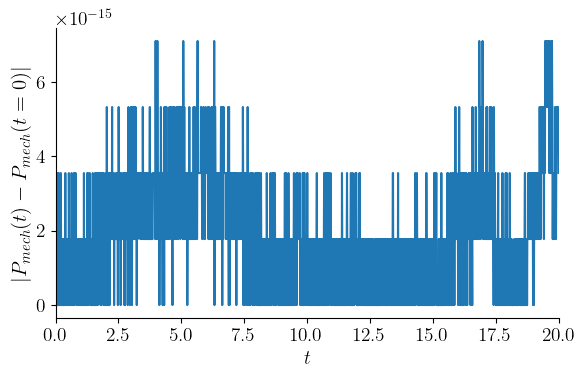

In [20]:
# plot momentum conservation
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(momentum_midpoint - momentum_midpoint[0]), "-")
#ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|P_{mech}(t)-P_{mech}(t=0)|$", fontsize=15)
ax.set_xlim(setup.T0, setup.T)
ax.set_xlabel("$t$")
plt.tight_layout()

### energy conservation

In [21]:
# compute energy (kinetic + potential) at each timestamp
energy_k_midpoint = np.zeros(len(sol_midpoint_t))
energy_p_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    energy_k_midpoint[ii] = total_energy_k_hermite(state=state_e_H[:, :-1, ii], alpha_s=setup.alpha, u_s=setup.u, dx=setup.dx, m_s=setup.m_e)\
                           +total_energy_k_legendre(state=state_e_L[:, :-1, ii], v_a=setup.v_a, v_b=setup.v_b, dx=setup.dx, m_s=setup.m_e)
    
    energy_p_midpoint[ii] = 0.5*setup.dx*np.sum((E_midpoint[:-1, ii])**2)

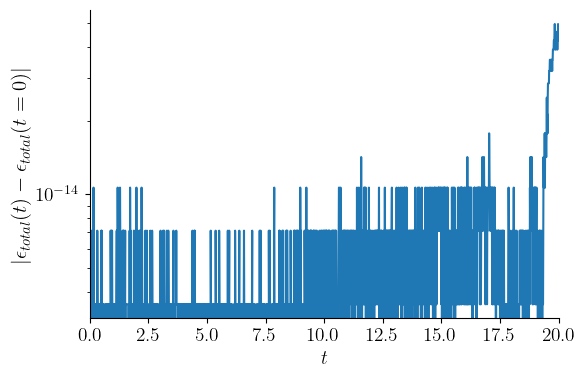

In [22]:
# plot energy conservation
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(energy_p_midpoint + energy_k_midpoint -energy_p_midpoint[0]-energy_k_midpoint[0]), "-")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|\mathcal{\epsilon}_{total}(t)-\mathcal{\epsilon}_{total}(t=0)|$", fontsize=15)
ax.set_xlabel("$t$")
ax.set_xlim(setup.T0, setup.T)
ax.set_yscale("log")
plt.tight_layout()

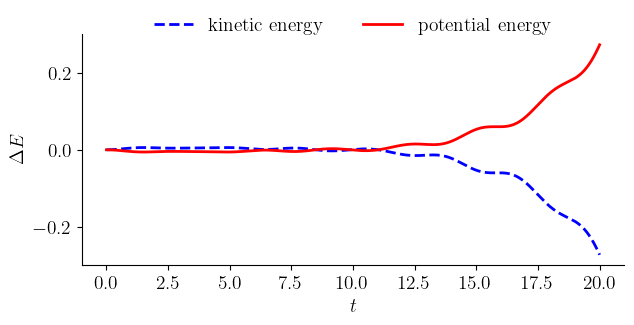

In [23]:
# plot the (kinetic + potential) energy exchange
fig, ax = plt.subplots(figsize=(7, 3))
plt.plot(sol_midpoint_t, energy_k_midpoint- energy_k_midpoint[0], label="kinetic energy", ls="--", linewidth=2, color="blue")
plt.plot(sol_midpoint_t, energy_p_midpoint- energy_p_midpoint[0], label="potential energy", linewidth=2, color="red")
legend = ax.legend(ncols=2, fontsize=14, loc='upper center', bbox_to_anchor=(0.5, 1.15))
legend.get_frame().set_alpha(0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("$t$")
_ = ax.set_ylabel(r"$\Delta E$")

### conservation summary

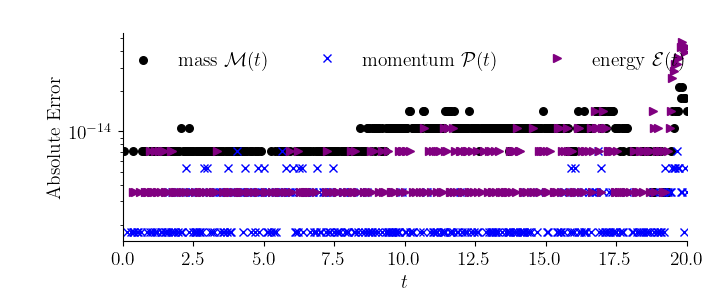

In [24]:
# plot the analytic and numerical conservation properties
skip = 5

fig, ax = plt.subplots(figsize=(7, 3))
ax.scatter(sol_midpoint_t[::skip], np.abs(mass_midpoint-mass_midpoint[0])[::skip], s=30, color="black", label=r"mass $\mathcal{M}(t)$")
ax.plot(sol_midpoint_t[::skip], np.abs(momentum_midpoint-momentum_midpoint[0])[::skip], "x", color="blue", label=r"momentum $\mathcal{P}(t)$")
ax.plot(sol_midpoint_t[::skip], np.abs(energy_p_midpoint + energy_k_midpoint -energy_p_midpoint[0]-energy_k_midpoint[0])[::skip], ">", color="purple", label=r"energy $\mathcal{E}(t)$")

ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"Absolute Error")
ax.set_xlabel("$t$")
ax.set_xlim(setup.T0, setup.T)
ax.set_yscale("log")
legend = ax.legend(ncols=3, fontsize=14, loc='upper center')
text = ax.text(-0.2,1.05, " ", transform=ax.transAxes)
legend.get_frame().set_alpha(0)
plt.tight_layout()